# Walmart Store Sales Forecast - In Progress

## Background Information

Data are provided by Walmart with 45 different stores located in different regions. Each store contains many departments and we will need to project the sales for each department in each store.  Also the holidays markdown are included in the dataset as well. Data is available at: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data


1. stores.csv: This file contains anonymized information about the 45 stores, indicating the type and size of store.


2. train.csv: This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

    Store - the store number <br>
    Dept - the department number <br>
    Date - the week <br>
    Weekly_Sales -  sales for the given department in the given store <br>
    IsHoliday - whether the week is a special holiday week <br>
    

3. test.csv: This file is identical to train.csv, except the actual weekly sales have been withheld. The task is to predict the sales for each store.


4. features.csv: This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week



# Import Packages and Data

In [40]:
#import packages
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

import datetime

In [2]:
# import data 
train = pd.read_csv("Data/train.csv")
test =pd.read_csv("Data/test.csv")
stores = pd.read_csv("Data/stores.csv")
features = pd.read_csv("Data/features.csv")

In [3]:
#inspect data
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


# Data Cleaning and manipulation

In the data cleaning, I will perform the following steps:

1.  Create an new column Weekly_Sales so we can combine train and test for cleaning purpose
2.  Create a store_id column by combining store number, department number, and date for training and testing data. Based on the original data, each row is record as weekly sales for that particular department in that store on the particular date. However, there is no unique identifier that we can identify each records for training and testing. 
3. Combine training and test for clean purpose
4. Join features tables and store tables to the new combined and train df
5. Replace markdown price Nan to 0 since Nan means no markdown at that time. 
6. Change date column to date format
6. Replace missing values 
7. Replace categorical values to dummy or numbers. If the category has more than 2 categories change to dummy otherwise replace with 1 or 0


## 1. Create an new column Weekly_Sales with test with null value

In [7]:
test['Weekly_Sales']= np.NaN

## 2. Create a store_id by combing store number, department number, and date for train/test

In [8]:
train['Store_Id'] = train[train.columns[:3]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

In [9]:
## 2b. Create a store_id by combing store number, department number, and date for test

test['Store_Id'] = test[test.columns[:3]].apply(lambda x: '_'.join(x.astype(str)), axis=1)


#sanity check 
display(train.head())
display(test.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Id
0,1,1,2010-02-05,24924.50,False,1_1_2010-02-05
1,1,1,2010-02-12,46039.49,True,1_1_2010-02-12
2,1,1,2010-02-19,41595.55,False,1_1_2010-02-19
3,1,1,2010-02-26,19403.54,False,1_1_2010-02-26
4,1,1,2010-03-05,21827.90,False,1_1_2010-03-05


,Store,Dept,Date,IsHoliday,Weekly_Sales,Store_Id
0,1,1,2012-11-02,False,NaN,1_1_2012-11-02
1,1,1,2012-11-09,False,NaN,1_1_2012-11-09
2,1,1,2012-11-16,False,NaN,1_1_2012-11-16
3,1,1,2012-11-23,True,NaN,1_1_2012-11-23
4,1,1,2012-11-30,False,NaN,1_1_2012-11-30


## 3. Combine Train and test data 

In [10]:
data = pd.concat([train,test])

#sanity check 
print(f'Shape for trian:{train.shape}')
print(f'Shape for test:{test.shape}')
print(f'Shape for data: {data.shape}')

data.head()

Shape for trian:(421570, 6)
Shape for test:(115064, 6)
Shape for data: (536634, 6)


,Date,Dept,IsHoliday,Store,Store_Id,Weekly_Sales
0,2010-02-05,1,False,1,1_1_2010-02-05,24924.50
1,2010-02-12,1,True,1,1_1_2010-02-12,46039.49
2,2010-02-19,1,False,1,1_1_2010-02-19,41595.55
3,2010-02-26,1,False,1,1_1_2010-02-26,19403.54
4,2010-03-05,1,False,1,1_1_2010-03-05,21827.90


## 4 Join stores to data. 

In [11]:
#join stores to data with Store number
data1 = pd.merge(data, stores, on='Store')

#sanity check
data1.head()

,Date,Dept,IsHoliday,Store,Store_Id,Weekly_Sales,Type,Size
0,2010-02-05,1,False,1,1_1_2010-02-05,24924.50,A,151315
1,2010-02-12,1,True,1,1_1_2010-02-12,46039.49,A,151315
2,2010-02-19,1,False,1,1_1_2010-02-19,41595.55,A,151315
3,2010-02-26,1,False,1,1_1_2010-02-26,19403.54,A,151315
4,2010-03-05,1,False,1,1_1_2010-03-05,21827.90,A,151315


In [12]:
# join features to data1 where store and date are multiple contidions and set store_id as index
df = pd.merge(data1, features, left_on=['Store','Date'], right_on=['Store', 'Date']).set_index('Store_Id')

#sanity check on df
df.head()

,Date,Dept,IsHoliday_x,Store,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Store_Id,,,,,,,,,,,,,,,,,
1_1_2010-02-05,2010-02-05,1,False,1,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1_2_2010-02-05,2010-02-05,2,False,1,50605.27,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1_3_2010-02-05,2010-02-05,3,False,1,13740.12,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1_4_2010-02-05,2010-02-05,4,False,1,39954.04,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1_5_2010-02-05,2010-02-05,5,False,1,32229.38,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


## 4. Replace MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5 Nan value to 0

In [13]:
#using for loops to replace madkdown columns Nan values to 0
cols = ['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']

for i in cols:
    df[i]= np.nan_to_num(df[i])

df.head()

,Date,Dept,IsHoliday_x,Store,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Store_Id,,,,,,,,,,,,,,,,,
1_1_2010-02-05,2010-02-05,1,False,1,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1_2_2010-02-05,2010-02-05,2,False,1,50605.27,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1_3_2010-02-05,2010-02-05,3,False,1,13740.12,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1_4_2010-02-05,2010-02-05,4,False,1,39954.04,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1_5_2010-02-05,2010-02-05,5,False,1,32229.38,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False


## Change Date column to date formate 

In [14]:
#Check Df summary info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536634 entries, 1_1_2010-02-05 to 45_98_2013-07-26
Data columns (total 17 columns):
Date            536634 non-null object
Dept            536634 non-null int64
IsHoliday_x     536634 non-null bool
Store           536634 non-null int64
Weekly_Sales    421570 non-null float64
Type            536634 non-null object
Size            536634 non-null int64
Temperature     536634 non-null float64
Fuel_Price      536634 non-null float64
MarkDown1       536634 non-null float64
MarkDown2       536634 non-null float64
MarkDown3       536634 non-null float64
MarkDown4       536634 non-null float64
MarkDown5       536634 non-null float64
CPI             498472 non-null float64
Unemployment    498472 non-null float64
IsHoliday_y     536634 non-null bool
dtypes: bool(2), float64(10), int64(3), object(2)
memory usage: 66.5+ MB


In [15]:
#change Date from string to date formate
df['Date'] = pd.to_datetime(df['Date'], format ='%Y-%m-%d')

In [16]:
#sanity check on date column
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

## Replace missing values for CPI and unemployment

In [24]:
#get NAN CPI in the features table
display(features['CPI'].isnull().sum())

#See first 5 rows with CPI missing. 
display(features[features['CPI'].isnull()].head())



585

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False


In [26]:
#get NAN Unemployment in the features table
features['Unemployment'].isnull().sum()


585

In [31]:
#check to see whether the missing CPI is also missing unemployment data 
features[features['CPI'].isnull()]['Unemployment'].isnull().sum()

585

In [22]:
#check how many years of CPI and Unemployment are missing in df
pd.DatetimeIndex(df[df['CPI'].isnull()]['Date']).year.value_counts()

2013    38162
Name: Date, dtype: int64

In [19]:
#check on how many years in the data
pd.DatetimeIndex(df['Date']).year.value_counts()

2012    154227
2011    153453
2010    140679
2013     88275
Name: Date, dtype: int64

Based on the aboved information, we can see the missing values for CPI and Unemployment rate are in 2013. We can check the average CPI and unemployment for each year and use the median number or average number based on the distribution of the avgerage store CPI to fill in the null value for 2013. Based on the null value testing of CPI and Unemployment, I can see that all of the rows that are missing CPI are also missing unemployment. 

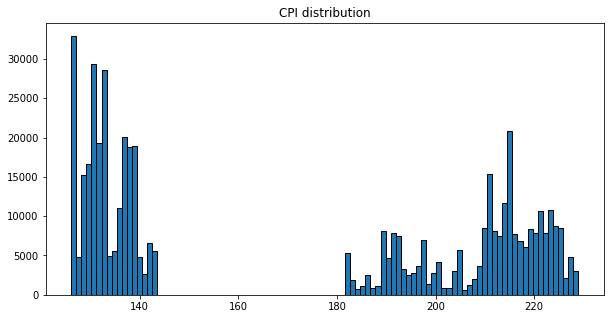

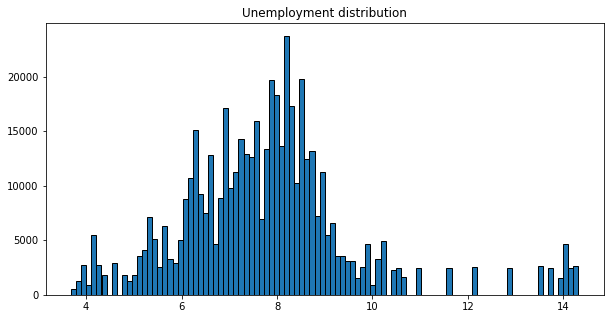

In [57]:
#check on the distribution of CPI and unemployment rate

plt.figure(figsize= (10,5))
plt.hist(df['CPI'], edgecolor = 'black', bins = 100)
plt.title('CPI distribution')
plt.show()

plt.figure(figsize=(10,5))
plt.hist(df['Unemployment'], edgecolor ='black', bins = 100)
plt.title('Unemployment distribution')
plt.show()

In [63]:
#get the stats info for CPI and Unemployment columns
df[['CPI','Unemployment']].describe()

,CPI,Unemployment
count,498472.000000,498472.000000
mean,172.090481,7.791888
std,39.542149,1.865076
min,126.064000,3.684000
25%,132.521867,6.623000
50%,182.442420,7.795000
75%,213.748126,8.549000
max,228.976456,14.313000


In [86]:
#get the mean, medium of the CPI for each store in 2010,2011,2012 
cpi_summary =df.groupby(['Store']).agg({'CPI':['mean','median']})

#unlist the column names
cpi_summary.columns = ['mean', 'median']

#add a column for mean, median difference
cpi_summary['difference'] = cpi_summary['mean'] - cpi_summary['median']

#view the result
cpi_summary

,mean,median,difference
Store,,,
1,217.271077,216.041053,1.230025
2,216.928356,215.694438,1.233918
3,220.704280,219.741491,0.962789
4,129.197705,129.430600,-0.232895
5,217.860702,216.603308,1.257393
6,218.853379,217.579751,1.273629
7,194.734315,194.809971,-0.075656
8,220.737076,219.444244,1.292831
9,220.993589,219.974642,1.018947


Based on the cpi summary table we can see that the average cpi for each store across three years is very similar to the mean of each store across three years. Therefore, I will simiply use the mean of each store across three years to fill the null values for each store in the df. 

In [132]:
# fill CPI na with mean of each store across three years

nulls = df.loc[df['CPI'].isnull(), 'Store']

df.loc[df['CPI'].isnull(),'CPI']= cpi_summary['mean'].loc[nulls].values

#sanity check 
df['CPI'].isnull().sum()

0

In [134]:
#get the mean, medium of the Unemployment for each store from 2010-2012 
unemployment_summary = df.groupby(['Store']).agg({'Unemployment':['mean','median']})

#unlist the column names
unemployment_summary.columns = ['mean', 'median']

#add a column for mean, median difference
unemployment_summary['difference'] = unemployment_summary['mean'] - unemployment_summary['median']

#view the result
unemployment_summary

,mean,median,difference
Store,,,
1,7.441328,7.742,-0.300672
2,7.402505,7.852,-0.449495
3,7.004116,7.343,-0.338884
4,5.648079,5.644,0.004079
5,6.163330,6.465,-0.301670
6,6.411231,6.855,-0.443769
7,8.376465,8.595,-0.218535
8,5.947410,6.262,-0.314590
9,5.923359,6.380,-0.456641


Similar to CPI, the difference between mean and median for the 3 year unemployment is not significant. Therefore, I will use similar method, using mean of the three years for each store to fill the unemployment nan values. 

In [135]:
# fill unemployment na with mean of each store across three years

nulls_u = df.loc[df['Unemployment'].isnull(), 'Store']

df.loc[df['Unemployment'].isnull(),'Unemployment']= unemployment_summary['mean'].loc[nulls_u].values

#sanity check 
df['Unemployment'].isnull().sum()

0

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536634 entries, 1_1_2010-02-05 to 45_98_2013-07-26
Data columns (total 16 columns):
Date            536634 non-null datetime64[ns]
Dept            536634 non-null int64
IsHoliday_x     536634 non-null bool
Store           536634 non-null int64
Weekly_Sales    421570 non-null float64
Type            536634 non-null object
Size            536634 non-null int64
Temperature     536634 non-null float64
Fuel_Price      536634 non-null float64
MarkDown1       536634 non-null float64
MarkDown2       536634 non-null float64
MarkDown3       536634 non-null float64
MarkDown4       536634 non-null float64
MarkDown5       536634 non-null float64
CPI             536634 non-null float64
Unemployment    536634 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 86.0+ MB


In [140]:
# drop extra column IsHoliday_y
df = df.drop(['IsHoliday_y'], axis=1)

# Data Exploration

In [143]:
df.shape

(536634, 16)

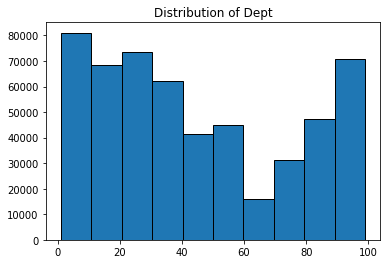

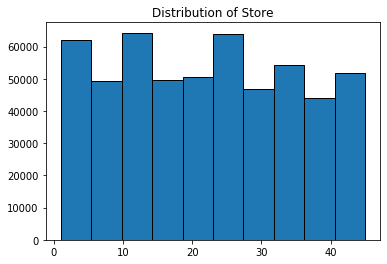

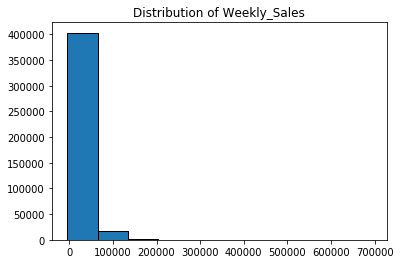

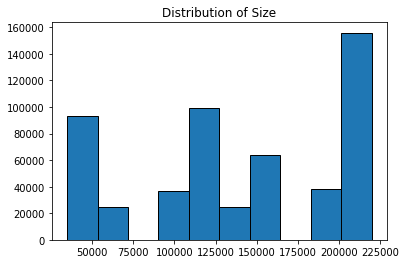

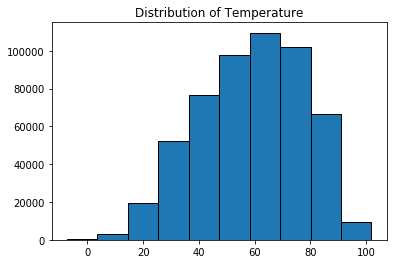

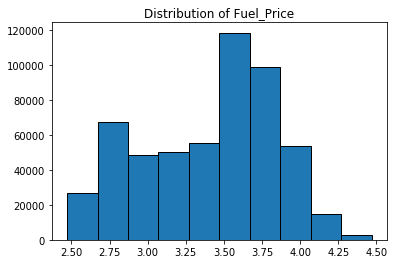

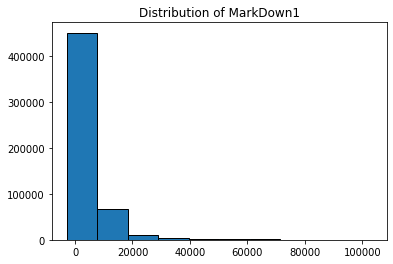

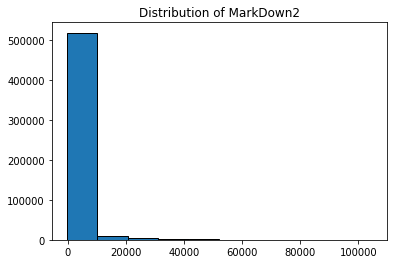

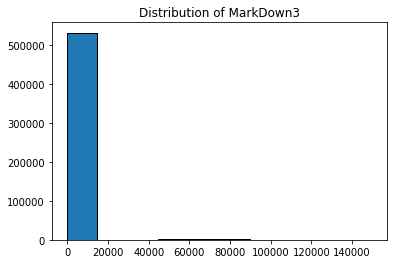

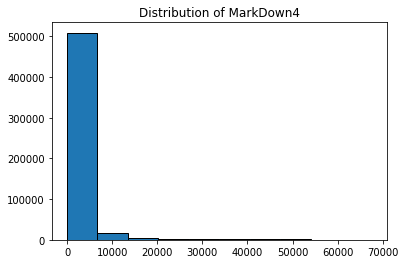

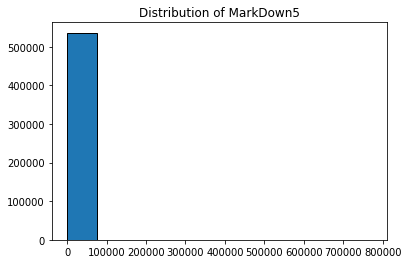

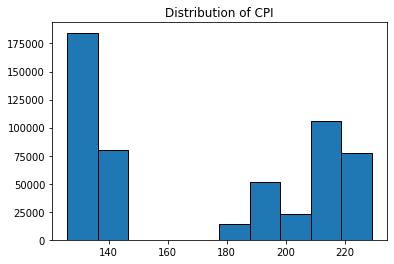

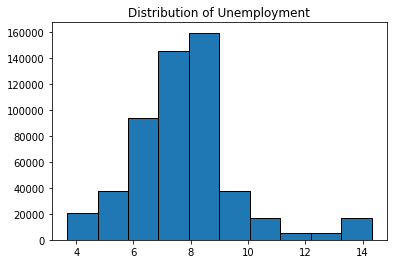

In [169]:
#plot histgram of each numerical columns to visulize the distribution 

numeric_col = [1,3,4,6,7,8,9,10,11,12,13,14,15]

for i in numeric_col:
    plt.figure()
    plt.hist(df[df.columns[i]], edgecolor='black')
    plt.title(f'Distribution of {df.columns[i]}')
    plt.show()

In [144]:
df.columns[1]

'Dept'